
# Lab Assignment — PCA Reconstruction Error & GD Variants (Momentum, NAG)

This notebook solves the two tasks you provided, using the **same three datasets** from earlier labs:
- **Iris** (scikit-learn)
- **Wine** (scikit-learn)
- **Titanic** (seaborn)

---

## Task 1 — Reconstruction error via Eigenfaces-style PCA
**Reference:** Turk & Pentland, *Eigenfaces for Recognition*, CVPR 1991.

We follow the exact pipeline:
1. Given data matrix **X** (rows = samples, columns = features). **Exclude the label/target**.
2. Compute column-wise mean **μ** and centered matrix **A = X - μ**.
3. Compute eigenvectors of **AᵀA** and sort by **descending eigenvalues**.
4. For a choice of components **n ∈ {1, 2, 3, 5, 7, 10, 15}** (limited by feature count), take the top-*n* eigenvectors: **Eₙ = [e₁,...,eₙ]**.
5. For each centered sample **aᵢ**, project: **w = Eₙᵀ aᵢ**; reconstruct **lᵢ = Eₙ w**; add back mean: **rᵢ = lᵢ + μ**.
6. Compute **reconstruction error** over the whole dataset: **Σ‖xᵢ − rᵢ‖²**.
7. Plot **error vs n** for each dataset.

---

## Task 2 — Gradient Descent Variants and Convergence Speed
Implement and compare:
- **Vanilla Gradient Descent (GD)**  
- **Momentum-based GD**  
- **Nesterov Accelerated Gradient (NAG)**  

We form a **linear regression** task on each dataset with a **continuous target**:
- Iris: predict **sepal length** from the other features.
- Wine: predict **alcohol** from the other features.
- Titanic: predict **fare** from available numeric features (after basic preprocessing).

We standardize features, run each optimizer, plot the **loss vs iterations**, and report the number of iterations to reach a chosen tolerance.


## Imports & Utilities

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_wine
import seaborn as sns

# Reproducibility
rng = np.random.default_rng(42)
np.set_printoptions(precision=4, suppress=True)

def standardize(X):
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True) + 1e-12
    return (X - mu) / sigma, mu, sigma


## Load Datasets and Prepare Feature Matrices (exclude labels)

In [2]:

# Iris
iris = load_iris(as_frame=True)
iris_df = iris.frame.copy()
X_iris = iris_df.drop(columns=['target']).values  # exclude label

# Wine
wine = load_wine(as_frame=True)
wine_df = wine.frame.copy()
X_wine = wine_df.drop(columns=['target']).values  # exclude label

# Titanic (seaborn): keep numeric columns and drop rows with all-nan numeric
titanic = sns.load_dataset('titanic')
titanic_num = titanic.select_dtypes(include=[np.number]).copy()
titanic_num = titanic_num.dropna(how='all')
# Simple impute remaining NaNs with column mean
titanic_num = titanic_num.fillna(titanic_num.mean(numeric_only=True))
X_titanic = titanic_num.values

print('Shapes:')
print('Iris   :', X_iris.shape)
print('Wine   :', X_wine.shape)
print('Titanic:', X_titanic.shape)


Shapes:
Iris   : (150, 4)
Wine   : (178, 13)
Titanic: (891, 6)


## Task 1 — PCA Reconstruction Error (Eigenfaces-style)

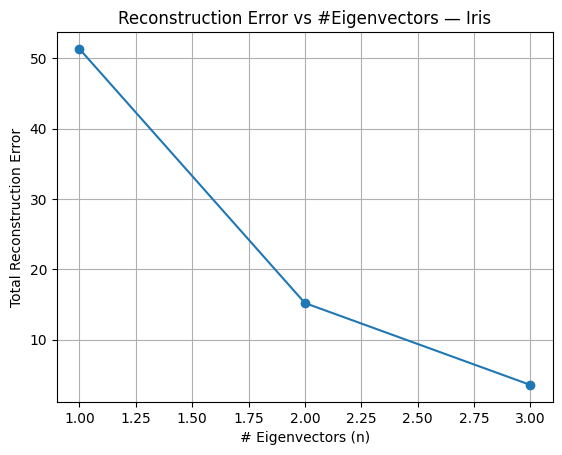

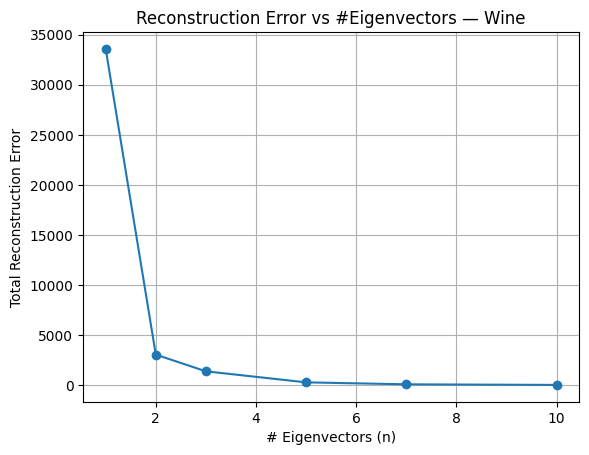

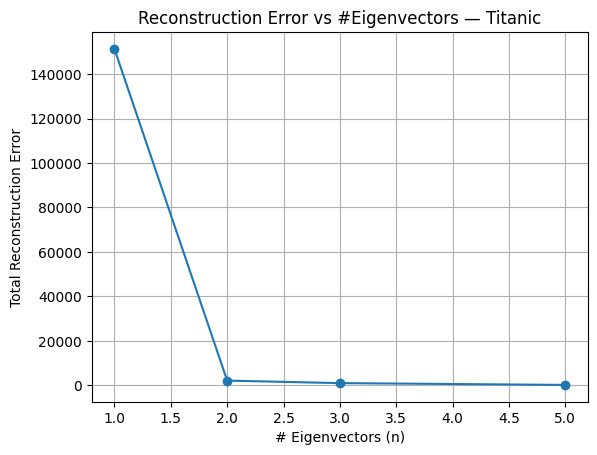


Iris
  n= 1 -> error=51.3626
  n= 2 -> error=15.2046
  n= 3 -> error=3.5514

Wine
  n= 1 -> error=33579.6389
  n= 2 -> error=3040.8967
  n= 3 -> error=1370.3506
  n= 5 -> error=269.4064
  n= 7 -> error=71.1598
  n=10 -> error=11.8328

Titanic
  n= 1 -> error=151339.9459
  n= 2 -> error=2094.8340
  n= 3 -> error=973.9289
  n= 5 -> error=162.6825


In [3]:

def pca_eigenfaces_style(X):
    # Center
    mu = X.mean(axis=0, keepdims=True)
    A = X - mu
    # Compute A^T A
    ATA = A.T @ A
    # Eigen decomposition (symmetric)
    vals, vecs = np.linalg.eigh(ATA)  # returns ascending
    order = np.argsort(vals)[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    return mu, A, vals, vecs

def reconstruction_error(X, mu, E):
    A = X - mu
    # project
    W = A @ E      # since E columns are eigenvectors of A^T A
    L = W @ E.T    # back to feature space
    R = L + mu
    err = ((X - R) ** 2).sum()
    return float(err)

def sweep_errors(X, n_list):
    mu, A, vals, vecs = pca_eigenfaces_style(X)
    n_list = [n for n in n_list if n <= vecs.shape[0] and n > 0]
    errs = []
    for n in n_list:
        E = vecs[:, :n]
        err = reconstruction_error(X, mu, E)
        errs.append(err)
    return n_list, errs

n_candidates = [1, 2, 3, 5, 7, 10, 15]

datasets = {
    'Iris'   : X_iris,
    'Wine'   : X_wine,
    'Titanic': X_titanic
}

errors_per_ds = {}
for name, X in datasets.items():
    n_list, errs = sweep_errors(X, n_candidates)
    errors_per_ds[name] = (n_list, errs)
    # Plot
    plt.figure()
    plt.title(f'Reconstruction Error vs #Eigenvectors — {name}')
    plt.plot(n_list, errs, marker='o')
    plt.xlabel('# Eigenvectors (n)')
    plt.ylabel('Total Reconstruction Error')
    plt.grid(True)
    plt.show()

# Tabulate
for name, (n_list, errs) in errors_per_ds.items():
    print(f'\n{name}')
    for n, e in zip(n_list, errs):
        print(f'  n={n:2d} -> error={e:.4f}')


## Task 2 — Gradient Descent Variants: Vanilla, Momentum, NAG (Linear Regression)

Running GD variants on all three datasets...


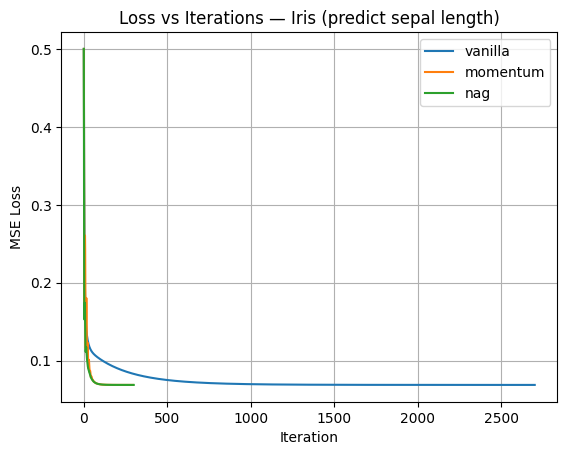

Iris (predict sepal length):
  vanilla   -> iters=2702, final loss=0.068906
  momentum  -> iters= 295, final loss=0.068904
  nag       -> iters= 300, final loss=0.068904


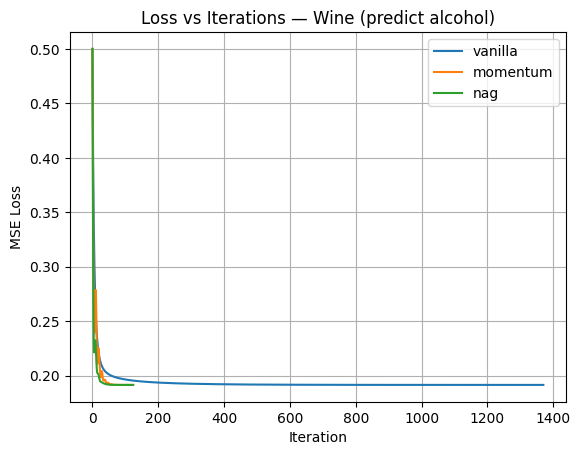

Wine (predict alcohol):
  vanilla   -> iters=1371, final loss=0.191520
  momentum  -> iters= 123, final loss=0.191519
  nag       -> iters= 125, final loss=0.191519


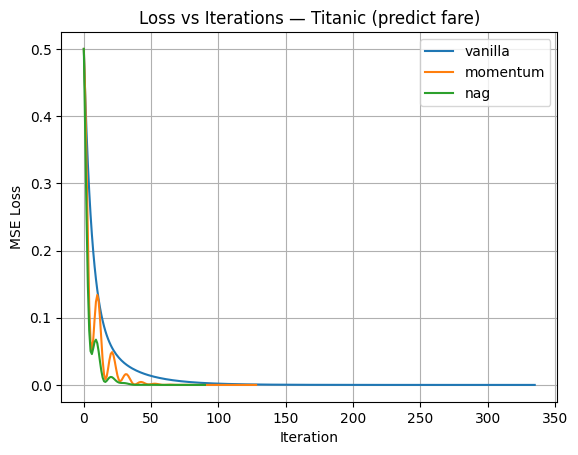

Titanic (predict fare):
  vanilla   -> iters= 336, final loss=0.000000
  momentum  -> iters= 129, final loss=0.000001
  nag       -> iters=  91, final loss=0.000000


In [4]:

def make_xy_for_regression():
    # Iris: predict sepal length from other features
    X_i = iris_df.drop(columns=['sepal length (cm)']).values
    y_i = iris_df['sepal length (cm)'].values

    # Wine: predict alcohol from other features
    X_w = wine_df.drop(columns=['alcohol']).values
    y_w = wine_df['alcohol'].values

    # Titanic: predict fare from numeric features (drop target-like columns if any)
    X_t = titanic_num.drop(columns=[c for c in ['survived'] if c in titanic_num.columns]).values
    y_t = titanic_num['fare'].values if 'fare' in titanic_num.columns else titanic_num.iloc[:, -1].values

    return (X_i, y_i), (X_w, y_w), (X_t, y_t)

(Xi, yi), (Xw, yw), (Xt, yt) = make_xy_for_regression()

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def mse_loss_and_grad(Xb, y, w):
    # predictions
    yhat = Xb @ w
    # loss
    err = yhat - y
    loss = 0.5 * np.mean(err**2)
    # gradient
    grad = (Xb.T @ err) / Xb.shape[0]
    return loss, grad

def gd_variants(X, y, eta=0.05, gamma=0.9, max_iters=5000, tol=1e-8, variant='vanilla'):
    # Standardize X and y for stable optimization
    Xs, muX, sX = standardize(X)
    ys, muy, sy = standardize(y.reshape(-1,1))
    ys = ys.ravel()

    Xb = add_bias(Xs)
    w = np.zeros(Xb.shape[1])
    v = np.zeros_like(w)

    losses = []
    for t in range(max_iters):
        # For NAG, lookahead
        if variant == 'nag':
            w_look = w - gamma * v
            loss, grad = mse_loss_and_grad(Xb, ys, w_look)
            v = gamma * v + eta * grad
            w = w - v
        else:
            loss, grad = mse_loss_and_grad(Xb, ys, w)
            if variant == 'momentum':
                v = gamma * v + eta * grad
                w = w - v
            else:  # vanilla
                w = w - eta * grad

        losses.append(loss)
        if t > 5 and abs(losses[-2] - losses[-1]) < tol:
            break

    return np.array(losses), t+1  # iterations executed

def run_all_variants(X, y, name, eta=0.05, gamma=0.9):
    res = {}
    for variant in ['vanilla', 'momentum', 'nag']:
        losses, iters = gd_variants(X, y, eta=eta, gamma=gamma, variant=variant)
        res[variant] = (losses, iters)

    # Plot loss curves
    plt.figure()
    plt.title(f'Loss vs Iterations — {name}')
    for variant, (losses, iters) in res.items():
        plt.plot(np.arange(len(losses)), losses, label=variant)
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print iterations to convergence
    print(f'{name}:')
    for variant, (losses, iters) in res.items():
        print(f'  {variant:9s} -> iters={iters:4d}, final loss={losses[-1]:.6f}')
    return res

print("Running GD variants on all three datasets...")
res_iris   = run_all_variants(Xi, yi, name='Iris (predict sepal length)')
res_wine   = run_all_variants(Xw, yw, name='Wine (predict alcohol)')
res_titanic= run_all_variants(Xt, yt, name='Titanic (predict fare)')
